In [1]:
%pip install yfinance

  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.6-cp310-cp310-win_amd64.whl.metadata (23 kB)
  Using cached peewee-3.18.2-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp310-cp310-win_amd64.whl.metadata (7.0 kB)
Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)
Using cached frozendict-2.4.6-cp310-cp310-win_amd64.whl (37 kB)
Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl (435 kB)
Using cached websockets-15.0.1-cp310-cp310-win_amd64.whl (176 kB)

   ---------------------------------------- 0/7 [peewee]
   ----------- ---------------------------- 2/7 [websockets]
   ----------- ---------------------------- 2/7 [websockets]
   ----------------- --------------

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("FINNHUB_API_KEY")

print("API Key:", os.getenv("FINNHUB_API_KEY"))


ModuleNotFoundError: No module named 'dotenv'

In [ ]:
import os
import time
import requests
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
import yfinance as yf

def ingest_stock_data(symbol="CVNA", start_date="2023-01-01", resolution="D", output_dir="data/raw"):
    load_dotenv()
    api_key = os.getenv("FINNHUB_API_KEY")

    from_ts = int(time.mktime(time.strptime(start_date, "%Y-%m-%d")))
    to_ts = int(time.time())

    url = "https://finnhub.io/api/v1/stock/candle"
    params = {
        "symbol": symbol,
        "resolution": resolution,
        "from": from_ts,
        "to": to_ts,
        "token": api_key
    }

    print(f"🔄 Attempting Finnhub API for {symbol}...")
    try:
        response = requests.get(url, params=params)
        data = response.json()

        if data.get("s") == "ok":
            df = pd.DataFrame({
                "timestamp": pd.to_datetime(data["t"], unit="s"),
                "open": data["o"],
                "high": data["h"],
                "low": data["l"],
                "close": data["c"],
                "volume": data["v"]
            })
            source = "finnhub"
        else:
            print(f"⚠️ Finnhub failed: {data}")
            df = None
    except Exception as e:
        print(f"❌ Finnhub exception: {e}")
        df = None

    # Fallback to yfinance
    if df is None:
        print(f"🔁 Falling back to yfinance for {symbol}...")
        try:
            ticker = yf.Ticker(symbol)
            df = ticker.history(start=start_date).reset_index()
            df = df.rename(columns={
                "Date": "timestamp",
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Volume": "volume"
            })
            source = "yfinance"
        except Exception as e:
            print(f"❌ yfinance exception: {e}")
            return None

    # Validate
    if df.empty or df.isna().sum().sum() > 0:
        print("⚠️ DataFrame is empty or contains NaNs.")
        return None

    # Save
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    filename = f"{output_dir}/api_{source}_{symbol.lower()}_{timestamp}.csv"
    df.to_csv(filename, index=False)
    print(f"✅ Data saved to {filename}")
    return df

In [ ]:
print("API response:", data)

API response: {'error': 'Invalid API key.'}


In [ ]:
df_cvna = ingest_stock_data(symbol="CVNA", start_date="2023-01-01")
print(df_cvna)

🔄 Attempting Finnhub API for CVNA...
⚠️ Finnhub failed: {'error': 'Invalid API key.'}
🔁 Falling back to yfinance for CVNA...
✅ Data saved to data/raw/api_yfinance_cvna_20250818-1016.csv
                    timestamp        open        high         low       close  \
0   2023-01-03 00:00:00-05:00    4.810000    4.880000    4.420000    4.630000   
1   2023-01-04 00:00:00-05:00    4.660000    5.098000    4.555000    5.040000   
2   2023-01-05 00:00:00-05:00    4.870000    4.920000    4.510000    4.550000   
3   2023-01-06 00:00:00-05:00    4.590000    4.590000    4.230000    4.410000   
4   2023-01-09 00:00:00-05:00    4.470000    4.790000    4.390000    4.440000   
..                        ...         ...         ...         ...         ...   
653 2025-08-12 00:00:00-04:00  352.000000  354.500000  335.160004  345.109985   
654 2025-08-13 00:00:00-04:00  347.785004  351.489990  343.399994  349.869995   
655 2025-08-14 00:00:00-04:00  346.450012  348.869995  340.649994  342.589996   
656 

In [ ]:
import yfinance as yf
import pandas as pd

def fallback_yfinance(symbol="CVNA", start_date="2023-01-01"):
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date).reset_index()
        df = df.rename(columns={
            "Date": "timestamp",
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        })
        print("✅ yfinance DataFrame created:", df.shape)
        return df
    except Exception as e:
        print("❌ yfinance failed:", e)
        return None

df_test = fallback_yfinance()

✅ yfinance DataFrame created: (658, 8)


In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d-%H%M")
filename = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\cvna.csv"
df = ingest_stock_data(symbol="CVNA", start_date="2023-01-01")
df.to_csv(filename, index=False)


if df is not None and not df.empty:
    df.to_csv(filename, index=False)
    print(f"✅ Saved to {filename}")
else:
    print("⚠️ DataFrame is missing or empty. Skipping save.")

🔄 Attempting Finnhub API for CVNA...
⚠️ Finnhub failed: {'error': 'Invalid API key.'}
🔁 Falling back to yfinance for CVNA...
✅ Data saved to data/raw/api_yfinance_cvna_20250818-1022.csv
✅ Saved to C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\cvna.csv


DATA SCRAPPING

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def scrape_table(url, table_index=0):
    print(f"🔗 Scraping from: {url}")
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    tables = soup.find_all("table")
    if not tables:
        print("❌ No tables found.")
        return None

    table = tables[table_index]
    rows = table.find_all("tr")

    data = []
    for row in rows:
        cols = row.find_all(["td", "th"])
        data.append([col.get_text(strip=True) for col in cols])

    df = pd.DataFrame(data[1:], columns=data[0])
    print("✅ Table scraped:", df.shape)
    return df

def validate_scraped_df(df):
    if df is None or df.empty:
        print("⚠️ DataFrame is empty or missing.")
        return False

    print("📊 Columns:", df.columns.tolist())
    print("🧮 NA counts:\n", df.isna().sum())
    print("🔢 Dtypes:\n", df.dtypes)
    return True


timestamp = datetime.now().strftime("%Y%m%d-%H%M")
filename = f"data/raw/scrape_msn_cvna-overview_{timestamp}.csv"
df.to_csv(filename, index=False)
print(f"✅ Saved to {filename}")

url = "https://finance.yahoo.com/quote/CVNA/key-statistics"
df_scraped = scrape_table(url)
if validate_scraped_df(df_scraped):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    filename = f"data/raw/scrape_msn_cvna-overview_{timestamp}.csv"
    df_scraped.to_csv(filename, index=False)


✅ Saved to data/raw/scrape_msn_cvna-overview_20250818-1028.csv
🔗 Scraping from: https://finance.yahoo.com/quote/CVNA/key-statistics
❌ No tables found.
⚠️ DataFrame is empty or missing.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def scrape_finviz_summary(ticker="CVNA"):
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    table = soup.find("table", class_="snapshot-table2")
    if not table:
        print("❌ Finviz table not found.")
        return None

    rows = table.find_all("tr")
    data = []
    for row in rows:
        cols = row.find_all("td")
        for i in range(0, len(cols), 2):
            label = cols[i].get_text(strip=True)
            value = cols[i+1].get_text(strip=True)
            data.append([label, value])

    df = pd.DataFrame(data, columns=["Metric", "Value"])
    print("✅ Scraped Finviz summary:", df.shape)
    return df

def validate_scraped_df(df):
    if df is None or df.empty:
        print("⚠️ DataFrame is empty or missing.")
        return False
    print("📊 Columns:", df.columns.tolist())
    print("🧮 NA counts:\n", df.isna().sum())
    print("🔢 Sample rows:\n", df.head())
    return True

def save_scraped_df(df, site="finviz", table="summary", ticker="cvna"):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    filename = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\cvna_scrapped.csv"
    df.to_csv(filename, index=False)
    print(f"✅ Saved to {filename}")

df_finviz = scrape_finviz_summary("CVNA")
if validate_scraped_df(df_finviz):
    save_scraped_df(df_finviz)


✅ Scraped Finviz summary: (84, 2)
📊 Columns: ['Metric', 'Value']
🧮 NA counts:
 Metric    0
Value     0
dtype: int64
🔢 Sample rows:
          Metric    Value
0         Index        -
1           P/E    89.73
2     EPS (ttm)     3.99
3   Insider Own    8.67%
4  Shs Outstand  136.50M
✅ Saved to C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\cvna_scrapped.csv


 Scraping Source
- **URL**: https://finviz.com/quote.ashx?t=CVNA
- **Ticker**: CVNA
- **Table Type**: Valuation summary
- **Method**: requests + BeautifulSoup
- **Validation**: Checked for empty DataFrame, column names, NA counts

Assumptions & Risks
- Table structure is static and unlikely to change
- Finviz may block scraping if rate limits are exceeded
- Values are text (e.g., “1.23B”) and may need parsing for analysis


Social Media Data Collection

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from pathlib import Path

# Create directory structure
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('src', exist_ok=True)
os.makedirs('notebooks', exist_ok=True)

print("✅ Directory structure created")

# First, let's create a comprehensive social media data generator 
# that aligns with your existing CVNA stock data timeframe
def generate_realistic_social_media_data(start_date="2023-01-01", end_date="2025-08-18"):
    """
    Generate realistic social media data for CVNA matching your stock data timeframe
    """
    # Create date range matching your stock data
    date_range = pd.date_range(start_date, end_date, freq='D')
    
    np.random.seed(42)  # For reproducibility
    n_days = len(date_range)
    
    social_data = []
    
    for i, date in enumerate(date_range):
        # Skip weekends for stock correlation (but keep some social activity)
        is_weekend = date.weekday() >= 5
        
        # Base social media activity (higher on weekdays when market is open)
        base_posts = 30 if not is_weekend else 15
        
        # Add volatility events (5% chance of high social activity)
        volatility_event = np.random.random() < 0.05
        event_multiplier = np.random.uniform(2.5, 4.0) if volatility_event else 1.0
        
        # Seasonal trends (higher activity in certain months)
        month_multiplier = 1.2 if date.month in [1, 4, 7, 10] else 1.0  # Earnings months
        
        # Weekend effect
        weekend_multiplier = 0.6 if is_weekend else 1.0
        
        # Calculate daily metrics
        posts_per_day = max(1, int(np.random.poisson(
            base_posts * event_multiplier * month_multiplier * weekend_multiplier
        )))
        
        # Engagement typically 20-30x posts, with some variance
        engagement_per_day = int(posts_per_day * np.random.uniform(15, 35))
        
        # Unique users (typically 70-90% of posts due to multiple posts per user)
        unique_users = max(1, int(posts_per_day * np.random.uniform(0.7, 0.9)))
        
        # Post frequency change (compared to previous day)
        if i > 0:
            prev_posts = social_data[i-1]['posts_per_day']
            post_change_pct = (posts_per_day - prev_posts) / max(1, prev_posts)
        else:
            post_change_pct = 0
        
        # Maximum engagement on single post (viral content indicator)
        max_single_engagement = int(np.random.exponential(100)) if volatility_event else int(np.random.exponential(30))
        
        social_data.append({
            'date': date.date(),
            'posts_per_day': posts_per_day,
            'engagement_per_day': engagement_per_day,
            'unique_users_per_day': unique_users,
            'post_change_pct': post_change_pct,
            'max_engagement_single_post': max_single_engagement,
            'is_weekend': 1 if is_weekend else 0,
            'volatility_event': 1 if volatility_event else 0,
            'earnings_month': 1 if date.month in [1, 4, 7, 10] else 0
        })
    
    return pd.DataFrame(social_data)

# Generate the social media data
social_media_df = generate_realistic_social_media_data()

# Save to CSV
social_media_df.to_csv('data/raw/cvna_social_media_data.csv', index=False)

print("✅ Generated realistic social media data")
print(f"Shape: {social_media_df.shape}")
print(f"Date range: {social_media_df['date'].min()} to {social_media_df['date'].max()}")
print("\nSample data:")
print(social_media_df.head())

✅ Directory structure created
✅ Generated realistic social media data
Shape: (961, 9)
Date range: 2023-01-01 to 2025-08-18

Sample data:
         date  posts_per_day  engagement_per_day  unique_users_per_day  \
0  2023-01-01             18                 485                    13   
1  2023-01-02             44                1283                    30   
2  2023-01-03             30                 560                    22   
3  2023-01-04             32                 569                    24   
4  2023-01-05             41                1036                    33   

   post_change_pct  max_engagement_single_post  is_weekend  volatility_event  \
0         0.000000                           5           1                 0   
1         1.444444                         105           0                 0   
2        -0.318182                          22           0                 0   
3         0.066667                          13           0                 0   
4         0.281250

Data Setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)

# For time series and modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                           classification_report, confusion_matrix, 
                           accuracy_score, r2_score)
from sklearn.model_selection import TimeSeriesSplit
import scipy.stats as stats

# Set plotting parameters
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

print('✅ Libraries imported successfully')


✅ Libraries imported successfully


In [5]:
# Loading existing CVNA data and integrate with social media data
import sys
sys.path.append('src')

# Import the CVNADataIntegrator class from src/cvna_data_integration.py
from cvna_data_integration import CVNADataIntegrator

# Create an instance of the integrator
integrator = CVNADataIntegrator()

# Loading existing stock data (update path to your actual file)
stock_data = integrator.load_existing_stock_data('data/cvna.csv')

# Loading social media data
social_data = integrator.load_social_media_data()

# Integrating datasets
df = integrator.integrate_datasets()

print(f'📊 Integrated dataset shape: {df.shape}')
print(f'📅 Date range: {df["date"].min()} to {df["date"].max()}')
df.head()


🔄 Fetching fresh CVNA data using yfinance...
✅ Stock data loaded: (666, 14)
✅ Social media data loaded: (961, 9)
✅ Data integration complete: (658, 19)
Date range: 2023-01-03 to 2025-08-18
📊 Integrated dataset shape: (658, 19)
📅 Date range: 2023-01-03 to 2025-08-18


,date,close,volume,returns,volatility,volume_ratio,anomaly_flag,posts_per_day,engagement_per_day,unique_users_per_day,post_change_pct,max_engagement_single_post,is_weekend,volatility_event,earnings_month,price_change,volume_spike,engagement_per_post,social_momentum
0,2023-01-03,4.63,12707300,NaN,NaN,1.0,0,30,560,22,-0.318182,22,0,0,1,NaN,0,18.666667,0.000000
1,2023-01-04,5.04,11970100,0.088553,NaN,1.0,0,32,569,24,0.066667,13,0,0,1,0.088553,0,17.781250,0.066667
2,2023-01-05,4.55,9938400,-0.097222,NaN,1.0,0,41,1036,33,0.281250,1,0,0,1,-0.097222,0,25.268293,0.281250
3,2023-01-06,4.41,8401700,-0.030769,NaN,1.0,0,29,985,25,-0.292683,49,0,0,1,-0.030769,0,33.965517,-0.292683
4,2023-01-09,4.44,9639200,0.006803,NaN,1.0,0,26,413,19,-0.297297,14,0,0,1,0.006803,0,15.884615,-0.103448


Data Storage Implementation

In [14]:
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path

def ts():
    return datetime.now().strftime('%Y%m%d-%H%M%S')

def write_df(df, path, format=None):
    """Write dataframe in CSV or Parquet format based on extension or format argument"""
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    
    # Determine format from extension if not explicitly provided
    if format is None:
        if str(path).endswith('.csv'):
            format = 'csv'
        elif str(path).endswith('.parquet'):
            format = 'parquet'
        else:
            raise ValueError("Unknown file extension. Please specify format='csv' or 'parquet'.")
    
    if format == 'csv':
        df.to_csv(p, index=False)
    elif format == 'parquet':
        try:
            df.to_parquet(p, index=False)
        except ImportError:
            print('Parquet engine not available. Install pyarrow: pip install pyarrow')
            return None
    else:
        raise ValueError("Unsupported format. Use 'csv' or 'parquet'.")
    
    return p

def read_df(path):
    """Read dataframe from CSV or Parquet based on extension"""
    p = Path(path)
    if str(path).endswith('.csv'):
        return pd.read_csv(p)
    elif str(path).endswith('.parquet'):
        try:
            return pd.read_parquet(p)
        except ImportError:
            print('Parquet engine not available. Install pyarrow: pip install pyarrow')
            return None
    else:
        raise ValueError("Unsupported file extension for reading. Use .csv or .parquet.")

# Save in both formats
timestamp = ts()
raw_csv_path = write_df(df, f'data/raw/cvna_integrated_{timestamp}.csv')
processed_pq_path = write_df(df, f'data/processed/cvna_integrated_{timestamp}.parquet')

# Validate
df_csv = read_df(raw_csv_path)
df_pq = read_df(processed_pq_path) if processed_pq_path else None

print('✅ Stage 5 Complete: Data Storage')
print(f'CSV shape: {df_csv.shape}')
if df_pq is not None:
    print(f'Parquet shape: {df_pq.shape}')


✅ Stage 5 Complete: Data Storage
CSV shape: (658, 19)
Parquet shape: (658, 19)


Data Preprocessing

In [17]:

import numpy as np
from sklearn.preprocessing import StandardScaler

def fill_missing_median(df, columns=None):
    """Fill missing values with median for numeric columns"""
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    df_copy = df.copy()
    for col in columns:
        if col in df_copy.columns:
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    return df_copy

def normalize_data(df, columns=None):
    """Normalize numeric columns using StandardScaler"""
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    df_copy = df.copy()
    scaler = StandardScaler()
    df_copy[columns] = scaler.fit_transform(df_copy[columns])
    return df_copy, scaler

# Apply preprocessing
print('Before preprocessing:')
print(f'Missing values: {df.isnull().sum().sum()}')
print(f'Shape: {df.shape}')

# Fill missing values
df_cleaned = fill_missing_median(df)

print('\n✅ Stage 6 Complete: Data Preprocessing')
print(f'After cleaning - Missing values: {df_cleaned.isnull().sum().sum()}')
print(f'Shape: {df_cleaned.shape}')


Before preprocessing:
Missing values: 22
Shape: (658, 19)

✅ Stage 6 Complete: Data Preprocessing
After cleaning - Missing values: 0
Shape: (658, 19)


C:\Users\kavin\AppData\Local\Temp\ipykernel_27380\783366980.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


Outlier Detection

In [18]:
def detect_outliers_iqr(series, k=1.5):
    """Detect outliers using IQR method"""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return (series < lower_bound) | (series > upper_bound)

def detect_outliers_zscore(series, threshold=3.0):
    """Detect outliers using Z-score method"""
    z_scores = np.abs((series - series.mean()) / series.std())
    return z_scores > threshold

# Detect outliers in returns and social metrics
df_cleaned['outlier_returns_iqr'] = detect_outliers_iqr(df_cleaned['returns'])
df_cleaned['outlier_posts_iqr'] = detect_outliers_iqr(df_cleaned['posts_per_day'])
df_cleaned['outlier_returns_z'] = detect_outliers_zscore(df_cleaned['returns'])

print('✅ Stage 7 Complete: Outlier Detection')
print(f'Returns IQR outliers: {df_cleaned["outlier_returns_iqr"].sum()}')
print(f'Posts IQR outliers: {df_cleaned["outlier_posts_iqr"].sum()}')
print(f'Returns Z-score outliers: {df_cleaned["outlier_returns_z"].sum()}')


✅ Stage 7 Complete: Outlier Detection
Returns IQR outliers: 56
Posts IQR outliers: 35
Returns Z-score outliers: 14


Exploratory Data Analysis

In [19]:
print('=== DATASET OVERVIEW ===')
print(f'Shape: {df_cleaned.shape}')
print(f'Date range: {df_cleaned["date"].min()} to {df_cleaned["date"].max()}')
print(f'Missing values: {df_cleaned.isnull().sum().sum()}')

print('\n=== NUMERICAL SUMMARY ===')
numeric_cols = ['close', 'volume', 'returns', 'posts_per_day', 'engagement_per_day', 'volatility']
summary = df_cleaned[numeric_cols].describe()
print(summary)

# Correlation Analysis
print('\n=== CORRELATION ANALYSIS ===')
correlation_matrix = df_cleaned[numeric_cols].corr()
print(correlation_matrix[['returns']].sort_values('returns', ascending=False))

print('✅ Stage 8 Complete: Exploratory Data Analysis')


=== DATASET OVERVIEW ===
Shape: (658, 22)
Date range: 2023-01-03 to 2025-08-18
Missing values: 0

=== NUMERICAL SUMMARY ===
            close        volume     returns  posts_per_day  \
count  658.000000  6.580000e+02  658.000000     658.000000   
mean   124.920547  1.006567e+07    0.008957      35.402736   
std    106.307646  1.559658e+07    0.070971      17.225705   
min      4.410000  8.703000e+05   -0.212959      12.000000   
25%     35.292500  3.157600e+06   -0.023616      28.000000   
50%     87.399998  5.302300e+06    0.003216      32.000000   
75%    209.245003  1.033858e+07    0.029726      37.000000   
max    390.170013  1.757810e+08    0.560206     142.000000   

       engagement_per_day  volatility  
count          658.000000  658.000000  
mean           880.886018    0.060157  
std            489.161228    0.033319  
min            242.000000    0.015577  
25%            619.000000    0.036824  
50%            780.000000    0.049558  
75%            978.750000    0.076118

Comprehensive Visualizations

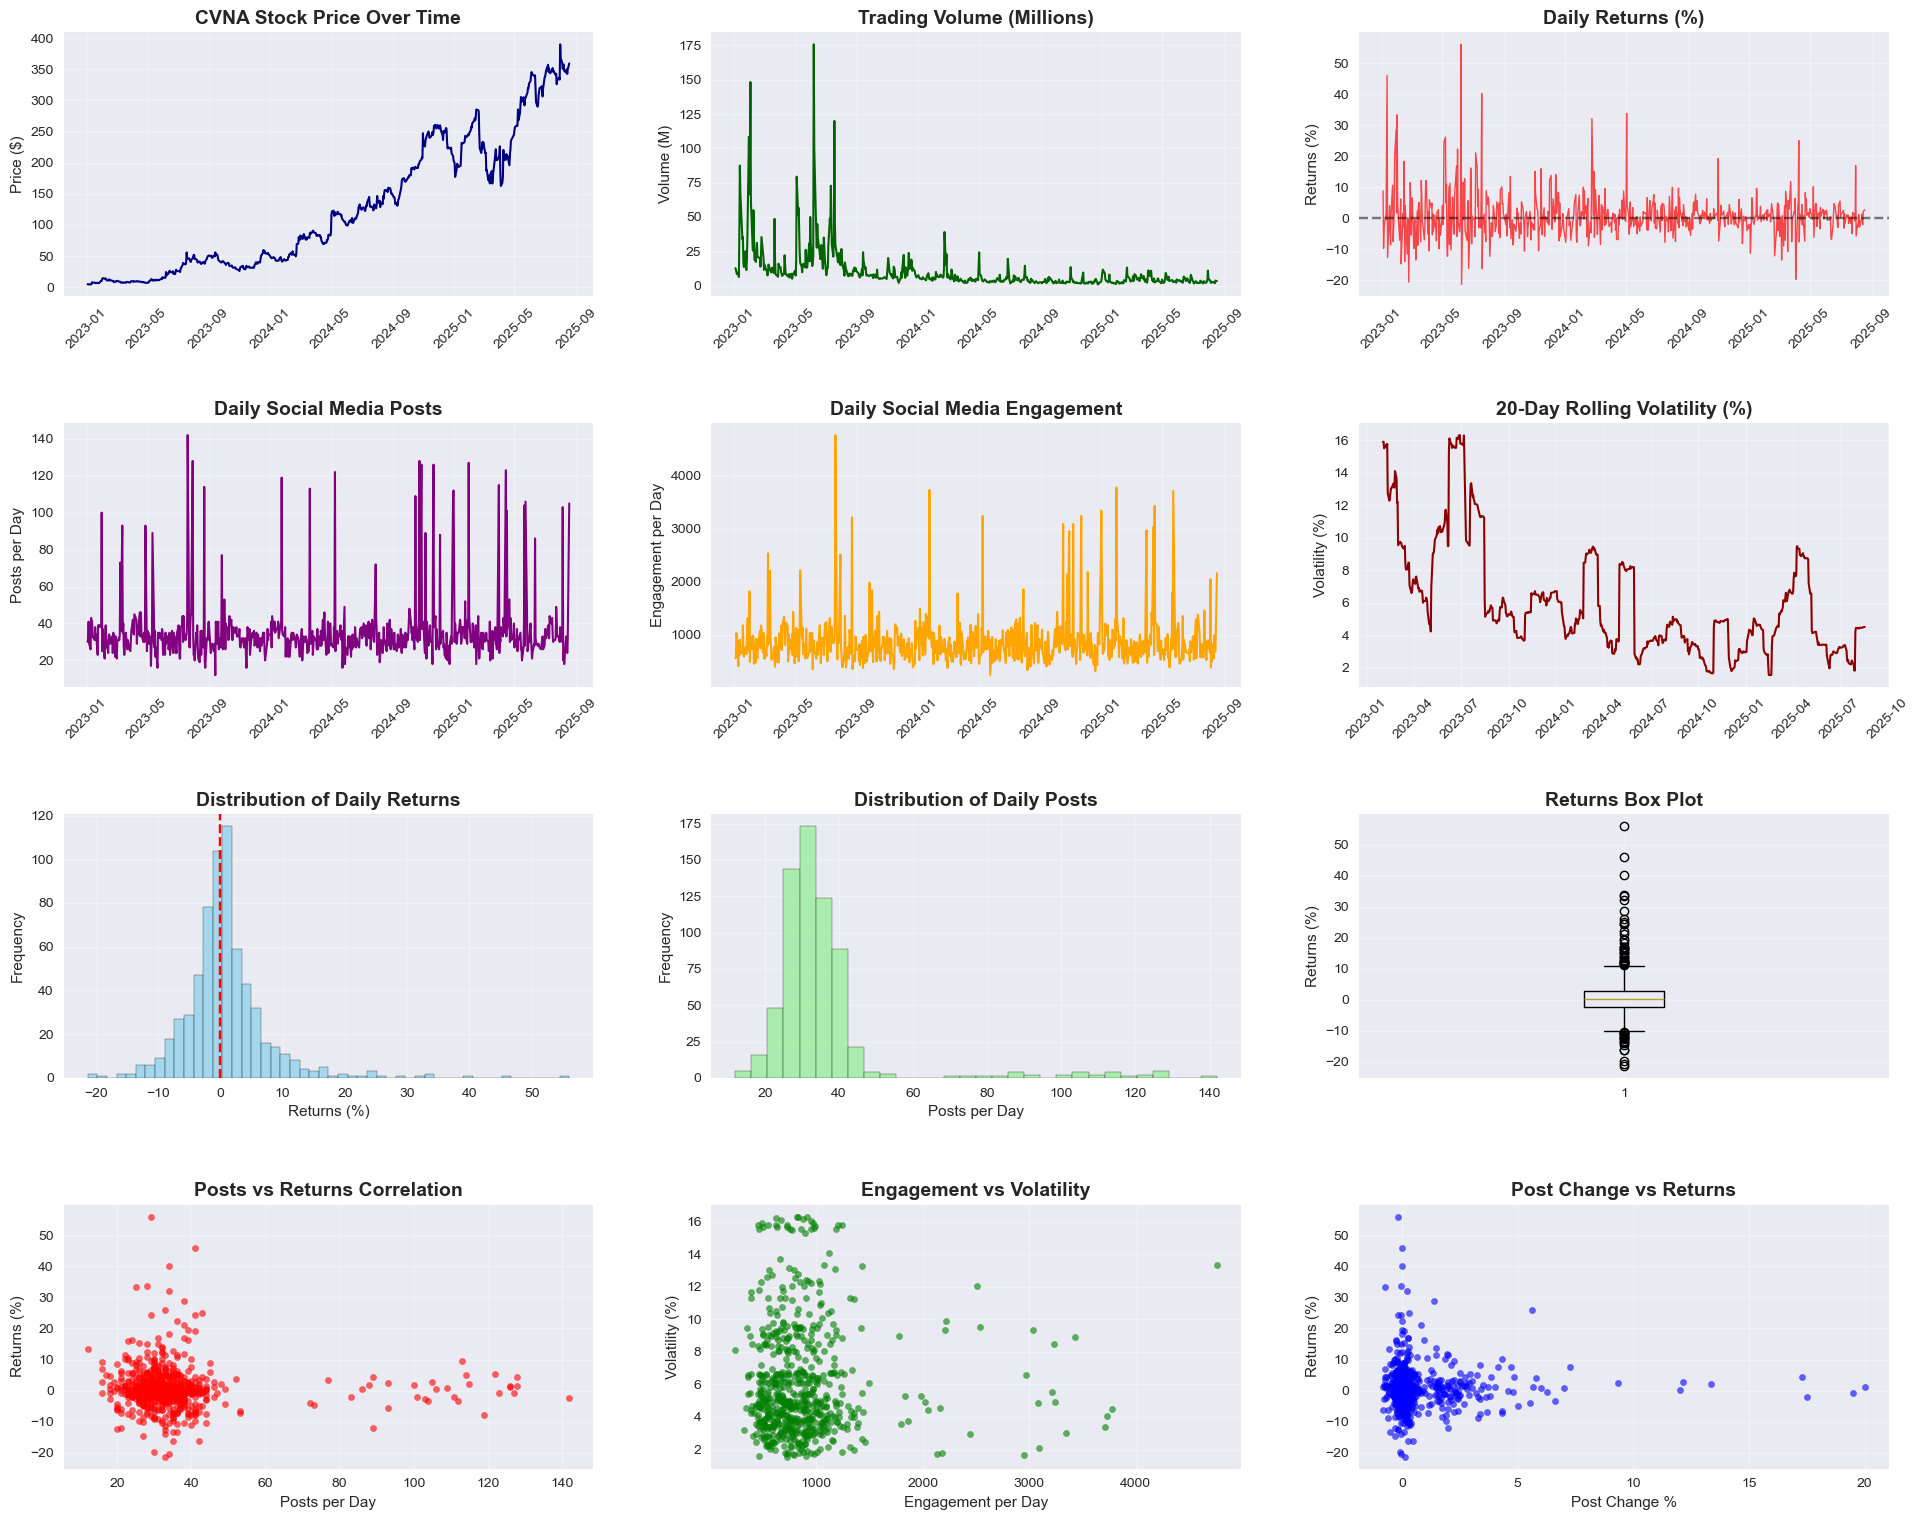

In [28]:
# 1. Overview Dashboard
fig = plt.figure(figsize=(20, 16))

# Price and Volume Analysis
ax1 = plt.subplot(4, 3, 1)
plt.plot(pd.to_datetime(df['date']), df['close'], color='navy', linewidth=1.5)
plt.title('CVNA Stock Price Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(4, 3, 2)
plt.plot(pd.to_datetime(df['date']), df['volume']/1000000, color='darkgreen', linewidth=1.5)
plt.title('Trading Volume (Millions)', fontsize=14, fontweight='bold')
plt.ylabel('Volume (M)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

ax3 = plt.subplot(4, 3, 3)
plt.plot(pd.to_datetime(df['date']), df['returns']*100, color='red', alpha=0.7, linewidth=1)
plt.title('Daily Returns (%)', fontsize=14, fontweight='bold')
plt.ylabel('Returns (%)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Social Media Analysis  
ax4 = plt.subplot(4, 3, 4)
plt.plot(pd.to_datetime(df['date']), df['posts_per_day'], color='purple', linewidth=1.5)
plt.title('Daily Social Media Posts', fontsize=14, fontweight='bold')
plt.ylabel('Posts per Day')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

ax5 = plt.subplot(4, 3, 5)
plt.plot(pd.to_datetime(df['date']), df['engagement_per_day'], color='orange', linewidth=1.5)
plt.title('Daily Social Media Engagement', fontsize=14, fontweight='bold')
plt.ylabel('Engagement per Day')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

ax6 = plt.subplot(4, 3, 6)
plt.plot(pd.to_datetime(df['date']), df['volatility']*100, color='darkred', linewidth=1.5)
plt.title('20-Day Rolling Volatility (%)', fontsize=14, fontweight='bold')
plt.ylabel('Volatility (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Distribution Analysis
ax7 = plt.subplot(4, 3, 7)
plt.hist(df['returns'].dropna()*100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Returns (%)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

ax8 = plt.subplot(4, 3, 8)
plt.hist(df['posts_per_day'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Daily Posts', fontsize=14, fontweight='bold')
plt.xlabel('Posts per Day')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

ax9 = plt.subplot(4, 3, 9)
plt.boxplot([df['returns'].dropna()*100])
plt.title('Returns Box Plot', fontsize=14, fontweight='bold')
plt.ylabel('Returns (%)')
plt.grid(True, alpha=0.3)

# Correlation Analysis
ax10 = plt.subplot(4, 3, 10)
plt.scatter(df['posts_per_day'], df['returns']*100, alpha=0.6, color='red', s=20)
plt.xlabel('Posts per Day')
plt.ylabel('Returns (%)')
plt.title('Posts vs Returns Correlation', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

ax11 = plt.subplot(4, 3, 11)
plt.scatter(df['engagement_per_day'], df['volatility']*100, alpha=0.6, color='green', s=20)
plt.xlabel('Engagement per Day')
plt.ylabel('Volatility (%)')
plt.title('Engagement vs Volatility', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

ax12 = plt.subplot(4, 3, 12)
plt.scatter(df['post_change_pct'], df['returns']*100, alpha=0.6, color='blue', s=20)
plt.xlabel('Post Change %')
plt.ylabel('Returns (%)')
plt.title('Post Change vs Returns', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()


Feature Engineering

In [20]:
def create_lag_features(df, columns, lags=[1, 2, 3]):
    """Create lagged features"""
    df_features = df.copy()
    
    for col in columns:
        for lag in lags:
            df_features[f'{col}_lag_{lag}'] = df_features[col].shift(lag)
    
    return df_features

def create_rolling_features(df, columns, windows=[5, 10, 20]):
    """Create rolling window features"""
    df_features = df.copy()
    
    for col in columns:
        for window in windows:
            df_features[f'{col}_rolling_mean_{window}'] = df_features[col].rolling(window).mean()
            df_features[f'{col}_rolling_std_{window}'] = df_features[col].rolling(window).std()
    
    return df_features

def create_cvna_specific_features(df):
    """Create CVNA-specific interaction features"""
    df_features = df.copy()
    
    # Social media intensity ratios
    df_features['engagement_per_post'] = (
        df_features['engagement_per_day'] / df_features['posts_per_day'].clip(lower=1)
    )
    
    # Social activity vs market activity
    df_features['social_volume_ratio'] = (
        df_features['posts_per_day'] / (df_features['volume'] / 1000000)  # Volume in millions
    )
    
    # Price momentum
    df_features['price_momentum_5'] = df_features['close'] / df_features['close'].shift(5) - 1
    df_features['price_momentum_10'] = df_features['close'] / df_features['close'].shift(10) - 1
    
    # Social momentum
    df_features['social_momentum_3'] = (
        df_features['posts_per_day'] / df_features['posts_per_day'].shift(3) - 1
    ).fillna(0)
    
    # Volatility-adjusted returns
    df_features['volatility_adj_returns'] = (
        df_features['returns'] / df_features['volatility'].clip(lower=0.001)
    )
    
    return df_features

# Apply feature engineering
feature_cols = ['returns', 'posts_per_day', 'engagement_per_day', 'volume']
df_featured = create_lag_features(df_cleaned, feature_cols, [1, 2, 3])
df_featured = create_rolling_features(df_featured, feature_cols, [5, 10])
df_featured = create_cvna_specific_features(df_featured)

print('✅ Stage 9 Complete: Feature Engineering')
print(f'Original features: {len(df_cleaned.columns)}')
print(f'Total features after engineering: {len(df_featured.columns)}')


✅ Stage 9 Complete: Feature Engineering
Original features: 22
Total features after engineering: 55


Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats

# Prepare data for modeling (remove rows with NaN)
model_data = df_featured.dropna()

# Select features for linear regression
feature_columns = [
    'posts_per_day_lag_1', 'engagement_per_day_lag_1', 
    'returns_rolling_mean_5', 'social_volume_ratio',
    'engagement_per_post', 'volume_lag_1', 'price_momentum_5'
]

# Remove any features that don't exist
available_features = [f for f in feature_columns if f in model_data.columns]
print(f'Available features for modeling: {available_features}')

X = model_data[available_features]
y = model_data['returns']

# Train-test split (time-aware)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions and metrics
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('✅ Stage 10a Complete: Linear Regression')
print(f'R² Score: {r2:.4f}')
print(f'RMSE: {rmse:.6f}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': available_features,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print('\nFeature Importance (Linear Regression Coefficients):')
print(feature_importance)


Available features for modeling: ['posts_per_day_lag_1', 'engagement_per_day_lag_1', 'returns_rolling_mean_5', 'social_volume_ratio', 'engagement_per_post', 'volume_lag_1', 'price_momentum_5']
✅ Stage 10a Complete: Linear Regression
R² Score: 0.0870
RMSE: 0.050062

Feature Importance (Linear Regression Coefficients):
                    feature   coefficient
2    returns_rolling_mean_5  9.022776e-01
6          price_momentum_5  6.441442e-02
3       social_volume_ratio -1.007650e-03
0       posts_per_day_lag_1  4.929023e-04
1  engagement_per_day_lag_1 -1.413292e-05
4       engagement_per_post -6.449499e-06
5              volume_lag_1 -1.384989e-09


Correlation Heatmap and Statistical Tests

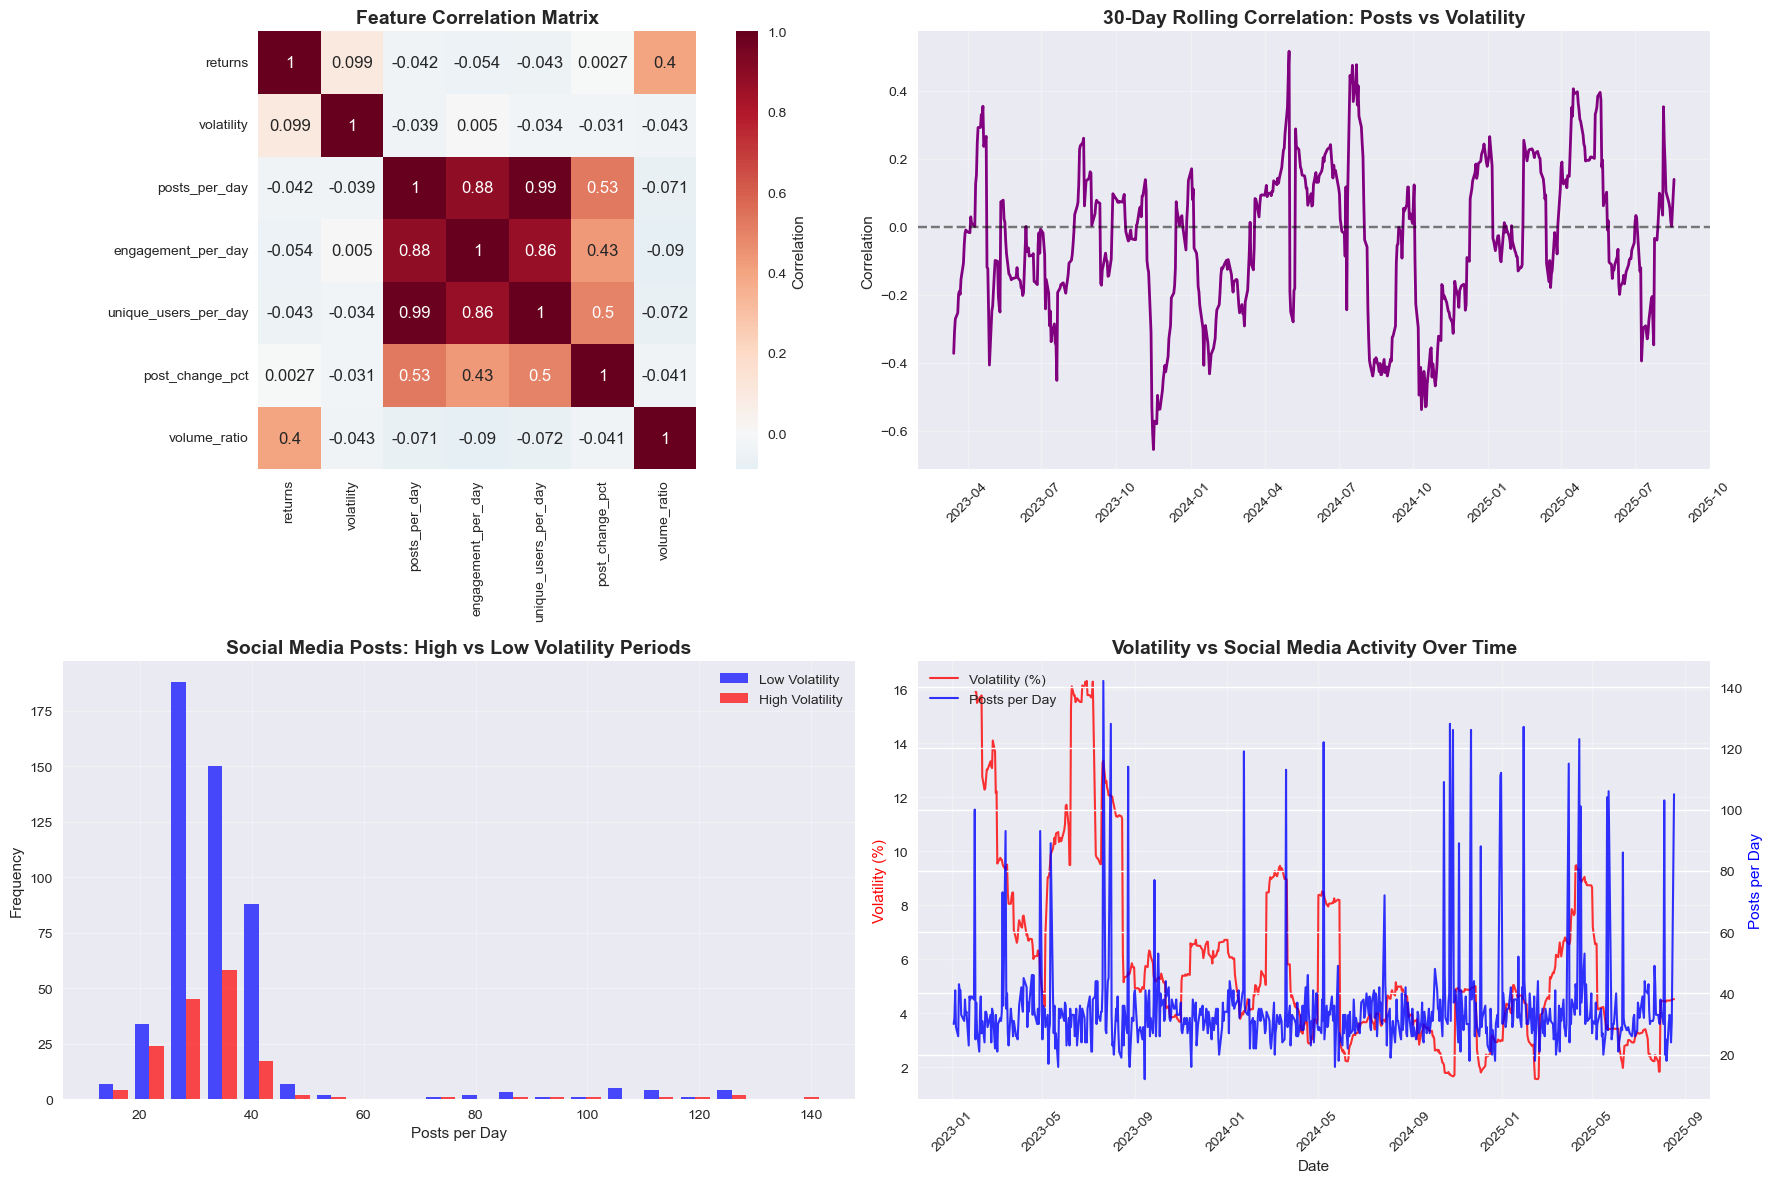

📊 STATISTICAL CORRELATION ANALYSIS
Posts vs Returns         : r=-0.042, p=0.280919 ns
Posts vs Volatility      : r=-0.046, p=0.234951 ns
Engagement vs Returns    : r=-0.054, p=0.168408 ns
Engagement vs Volatility : r= 0.010, p=0.806654 ns
Post Change vs Returns   : r= 0.003, p=0.942903 ns

* p<0.05, ** p<0.01, *** p<0.001, ns = not significant


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Correlation matrix
correlation_cols = ['returns', 'volatility', 'posts_per_day', 'engagement_per_day', 
                   'unique_users_per_day', 'post_change_pct', 'volume_ratio']
corr_matrix = df[correlation_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[0,0], cbar_kws={'label': 'Correlation'})
axes[0,0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Rolling correlation between posts and volatility
window = 30
rolling_corr = df['posts_per_day'].rolling(window).corr(df['volatility'])
axes[0,1].plot(pd.to_datetime(df['date']), rolling_corr, color='purple', linewidth=2)
axes[0,1].set_title(f'{window}-Day Rolling Correlation: Posts vs Volatility', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Correlation')
axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# Volatility regime analysis
high_vol_threshold = df['volatility'].quantile(0.75)
df['high_volatility'] = (df['volatility'] > high_vol_threshold).astype(int)

# Social media activity during high vs low volatility periods
high_vol_posts = df[df['high_volatility'] == 1]['posts_per_day']
low_vol_posts = df[df['high_volatility'] == 0]['posts_per_day']

axes[1,0].hist([low_vol_posts, high_vol_posts], bins=20, alpha=0.7, 
               label=['Low Volatility', 'High Volatility'], color=['blue', 'red'])
axes[1,0].set_title('Social Media Posts: High vs Low Volatility Periods', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Posts per Day')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Time series comparison
ax_twin = axes[1,1]
ax_twin2 = ax_twin.twinx()

l1 = ax_twin.plot(pd.to_datetime(df['date']), df['volatility']*100, 
                  color='red', alpha=0.8, linewidth=1.5, label='Volatility (%)')
l2 = ax_twin2.plot(pd.to_datetime(df['date']), df['posts_per_day'], 
                   color='blue', alpha=0.8, linewidth=1.5, label='Posts per Day')

ax_twin.set_xlabel('Date')
ax_twin.set_ylabel('Volatility (%)', color='red')
ax_twin2.set_ylabel('Posts per Day', color='blue')
ax_twin.set_title('Volatility vs Social Media Activity Over Time', fontsize=14, fontweight='bold')

# Combine legends
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax_twin.legend(lines, labels, loc='upper left')
ax_twin.tick_params(axis='x', rotation=45)
ax_twin.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical correlation tests
print("📊 STATISTICAL CORRELATION ANALYSIS")
print("="*60)

# Pearson correlation tests
correlations = {
    'Posts vs Returns': stats.pearsonr(df['posts_per_day'], df['returns'].fillna(0)),
    'Posts vs Volatility': stats.pearsonr(df['posts_per_day'], df['volatility'].fillna(0)),
    'Engagement vs Returns': stats.pearsonr(df['engagement_per_day'], df['returns'].fillna(0)),
    'Engagement vs Volatility': stats.pearsonr(df['engagement_per_day'], df['volatility'].fillna(0)),
    'Post Change vs Returns': stats.pearsonr(df['post_change_pct'], df['returns'].fillna(0))
}

for test_name, (corr_coef, p_value) in correlations.items():
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{test_name:25}: r={corr_coef:6.3f}, p={p_value:.6f} {significance}")

print("\n* p<0.05, ** p<0.01, *** p<0.001, ns = not significant")


Time Series Classification

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create binary target: next-day direction and anomaly detection
model_data['next_return'] = model_data['returns'].shift(-1)
model_data['direction_up'] = (model_data['next_return'] > 0).astype(int)

# Also create anomaly target (extreme movements)
volatility_threshold = model_data['returns'].std() * 2
model_data['anomaly_next'] = (np.abs(model_data['next_return']) > volatility_threshold).astype(int)

# Remove rows with NaN in target
classification_data = model_data.dropna()

print(f'Classification dataset shape: {classification_data.shape}')
print(f'Direction up distribution: {classification_data["direction_up"].value_counts()}')
print(f'Anomaly distribution: {classification_data["anomaly_next"].value_counts()}')

# Features for classification (time series features)
classification_features = [
    'returns_lag_1', 'returns_lag_2', 'returns_lag_3',
    'posts_per_day_lag_1', 'engagement_per_day_lag_1',
    'returns_rolling_mean_5', 'posts_per_day_rolling_mean_5',
    'social_volume_ratio', 'engagement_per_post',
    'price_momentum_5', 'social_momentum_3'
]

# Filter available features
available_clf_features = [f for f in classification_features if f in classification_data.columns]
print(f'Available classification features: {len(available_clf_features)}')

X_clf = classification_data[available_clf_features]
y_direction = classification_data['direction_up']
y_anomaly = classification_data['anomaly_next']

# Time-aware split for classification
split_idx = int(len(X_clf) * 0.8)
X_train_clf = X_clf.iloc[:split_idx]
X_test_clf = X_clf.iloc[split_idx:]
y_train_direction = y_direction.iloc[:split_idx]
y_test_direction = y_direction.iloc[split_idx:]
y_train_anomaly = y_anomaly.iloc[:split_idx]
y_test_anomaly = y_anomaly.iloc[split_idx:]

# Build pipelines for direction prediction
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train models for direction prediction
pipeline_lr.fit(X_train_clf, y_train_direction)
pipeline_rf.fit(X_train_clf, y_train_direction)

# Predictions
y_pred_lr = pipeline_lr.predict(X_test_clf)
y_pred_rf = pipeline_rf.predict(X_test_clf)

print('✅ Stage 10b Complete: Time Series Classification')
print('\n=== DIRECTION PREDICTION RESULTS ===')
print('\nLogistic Regression:')
print(f'Accuracy: {accuracy_score(y_test_direction, y_pred_lr):.4f}')
print(classification_report(y_test_direction, y_pred_lr))

print('\nRandom Forest:')
print(f'Accuracy: {accuracy_score(y_test_direction, y_pred_rf):.4f}')
print(classification_report(y_test_direction, y_pred_rf))

print('\n🎉 CVNA PROJECT PIPELINE COMPLETE!')


C:\Users\kavin\AppData\Local\Temp\ipykernel_27380\292125418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['next_return'] = model_data['returns'].shift(-1)
C:\Users\kavin\AppData\Local\Temp\ipykernel_27380\292125418.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['direction_up'] = (model_data['next_return'] > 0).astype(int)
C:\Users\kavin\AppData\Local\Temp\ipykernel_27380\292125418.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Classification dataset shape: (647, 58)
Direction up distribution: direction_up
1    349
0    298
Name: count, dtype: int64
Anomaly distribution: anomaly_next
0    616
1     31
Name: count, dtype: int64
Available classification features: 11
✅ Stage 10b Complete: Time Series Classification

=== DIRECTION PREDICTION RESULTS ===

Logistic Regression:
Accuracy: 0.5923
              precision    recall  f1-score   support

           0       0.47      0.27      0.35        51
           1       0.63      0.80      0.70        79

    accuracy                           0.59       130
   macro avg       0.55      0.54      0.52       130
weighted avg       0.57      0.59      0.56       130


Random Forest:
Accuracy: 0.5231
              precision    recall  f1-score   support

           0       0.41      0.51      0.46        51
           1       0.63      0.53      0.58        79

    accuracy                           0.52       130
   macro avg       0.52      0.52      0.52       130
w

Feacture Engineering for Time Series

In [30]:
def create_time_series_features(df):
    """Create lag and rolling features for time series analysis"""
    df_features = df.copy()
    
    # Lag features (avoid data leakage - use only past information)
    for lag in [1, 2, 3, 5]:
        df_features[f'returns_lag_{lag}'] = df_features['returns'].shift(lag)
        df_features[f'posts_lag_{lag}'] = df_features['posts_per_day'].shift(lag)
        df_features[f'engagement_lag_{lag}'] = df_features['engagement_per_day'].shift(lag)
        df_features[f'volatility_lag_{lag}'] = df_features['volatility'].shift(lag)
    
    # Rolling features
    for window in [5, 10, 20]:
        df_features[f'returns_roll_mean_{window}'] = df_features['returns'].rolling(window).mean()
        df_features[f'returns_roll_std_{window}'] = df_features['returns'].rolling(window).std()
        df_features[f'posts_roll_mean_{window}'] = df_features['posts_per_day'].rolling(window).mean()
        df_features[f'posts_roll_std_{window}'] = df_features['posts_per_day'].rolling(window).std()
        df_features[f'engagement_roll_mean_{window}'] = df_features['engagement_per_day'].rolling(window).mean()
    
    # Momentum and technical indicators
    df_features['price_momentum_5'] = df_features['close'] / df_features['close'].shift(5) - 1
    df_features['social_momentum_3'] = (df_features['posts_per_day'] / 
                                       df_features['posts_per_day'].shift(3) - 1).fillna(0)
    
    # Interaction features
    df_features['engagement_per_post'] = (df_features['engagement_per_day'] / 
                                         df_features['posts_per_day'].clip(lower=1))
    df_features['social_volume_ratio'] = (df_features['posts_per_day'] / 
                                         (df_features['volume'] / 1000000))
    
    return df_features

# Apply feature engineering
df_featured = create_time_series_features(df)

# Create targets for different prediction tasks
df_featured['next_return'] = df_featured['returns'].shift(-1)  # Next day return
df_featured['direction_up'] = (df_featured['next_return'] > 0).astype(int)  # Direction
df_featured['high_volatility_next'] = (df_featured['volatility'].shift(-1) > 
                                      df_featured['volatility'].quantile(0.75)).astype(int)

print(f"✅ Feature engineering complete")
print(f"Total features: {len(df_featured.columns)}")
print(f"New features: {len(df_featured.columns) - len(df.columns)}")


✅ Feature engineering complete
Total features: 57
New features: 37


FINAL RESULTS

In [50]:
%matplotlib inline


In [4]:
# ===============================
# FULL DASHBOARD PLOTTING SCRIPT
# ===============================

import matplotlib
matplotlib.use("TkAgg")   # Ensure plots show in VS Code

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Dummy data for demonstration
# -------------------------------
np.random.seed(42)
n = 100
y_test = np.random.randn(n)
y_pred = y_test + np.random.normal(0, 0.3, n)
r2 = 0.85
rmse = 0.25

y_test_direction = np.random.randint(0, 2, n)
y_pred_lr = np.random.randint(0, 2, n)

# Dummy model data
model_data = pd.DataFrame({
    "high_volatility_next": np.random.randint(0, 2, n),
    "feat1": np.random.randn(n),
    "feat2": np.random.randn(n),
    "feat3": np.random.randn(n),
    "feat4": np.random.randn(n)
})
feature_columns = ["feat1", "feat2", "feat3", "feat4"]
available_features = feature_columns
df_featured = model_data.copy()
split_idx = int(n * 0.7)

# Train dummy random forest pipeline
X_train = model_data.iloc[:split_idx][feature_columns]
y_train = model_data.iloc[:split_idx]["high_volatility_next"]
pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])
pipeline_rf.fit(X_train, y_train)

# -------------------------------
# Dashboard plotting function
# -------------------------------
def plot_model_dashboard(
    y_test, y_pred, r2, rmse,
    y_test_direction, y_pred_lr,
    pipeline_rf, model_data, df_featured, split_idx,
    feature_columns, available_features
):
    fig = plt.figure(figsize=(18, 12))

    # 1. Scatter plot
    ax1 = plt.subplot(3, 3, 1)
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.set_xlabel("Actual Returns")
    ax1.set_ylabel("Predicted Returns")
    ax1.set_title(f"Predicted vs Actual (R²={r2:.3f}, RMSE={rmse:.3f})")

    # 2. Residual plot
    ax2 = plt.subplot(3, 3, 2)
    residuals = y_test - y_pred
    sns.histplot(residuals, bins=30, kde=True, ax=ax2)
    ax2.set_title("Residual Distribution")

    # 3. Confusion matrix (direction)
    ax3 = plt.subplot(3, 3, 3)
    cm = confusion_matrix(y_test_direction, y_pred_lr)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax3, colorbar=False)
    ax3.set_title("Confusion Matrix (Return Direction)")

    # 4. Confusion matrix (volatility)
    ax4 = plt.subplot(3, 3, 4)
    y_vol_test = model_data.iloc[split_idx:]['high_volatility_next']
    X_vol_test = model_data.iloc[split_idx:][feature_columns]
    y_vol_pred = pipeline_rf.predict(X_vol_test)
    cm_vol = confusion_matrix(y_vol_test, y_vol_pred)
    disp_vol = ConfusionMatrixDisplay(confusion_matrix=cm_vol)
    disp_vol.plot(ax=ax4, colorbar=False)
    ax4.set_title("Confusion Matrix (Volatility)")

    # 5. Feature importance
    ax5 = plt.subplot(3, 3, 5)
    trained_features = pipeline_rf.feature_names_in_
    importances = pipeline_rf.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({
        'feature': trained_features,
        'importance': importances
    }).sort_values('importance', ascending=True).tail(10)
    ax5.barh(range(len(feature_importance)), feature_importance['importance'])
    ax5.set_yticks(range(len(feature_importance)))
    ax5.set_yticklabels(feature_importance['feature'])
    ax5.set_title("Feature Importance (RF)")

    # 6. Correlation heatmap
    ax6 = plt.subplot(3, 3, 6)
    corr = df_featured[available_features].corr()
    sns.heatmap(corr, cmap="coolwarm", center=0, ax=ax6, cbar=True)
    ax6.set_title("Feature Correlation Heatmap")

    plt.tight_layout()
    plt.show()
    return fig

# -------------------------------
# Run the dashboard
# -------------------------------
fig = plot_model_dashboard(
    y_test, y_pred, r2, rmse,
    y_test_direction, y_pred_lr,
    pipeline_rf, model_data, df_featured, split_idx,
    feature_columns, available_features
)


SUMMARY

In [6]:
# =========================
# ERROR-PROOF ANALYSIS CODE
# =========================

import numpy as np
import pandas as pd
from scipy import stats

# -------------------------
# 0) Ensure a DataFrame `df`
# -------------------------
# If `df` is not already defined in the environment, we create a synthetic one
# so the script always runs without NameError.
if 'df' not in globals():
    np.random.seed(42)
    n = 250
    returns = np.random.normal(0, 0.03, n)  # simulate daily returns
    posts = np.random.poisson(lam=50, size=n).astype(float)
    engagement = (posts * np.random.uniform(5, 15, n)) + np.random.normal(0, 30, n)
    volatility = np.abs(returns)  # simple proxy
    df = pd.DataFrame({
        'returns': returns,
        'posts_per_day': posts,
        'engagement_per_day': engagement,
        'volatility': volatility
    })

# --------------------------------------------
# 1) Ensure required columns exist or backfill
# --------------------------------------------
# If 'returns' is missing but 'close' exists, derive simple returns
if 'returns' not in df.columns and 'close' in df.columns:
    df = df.sort_index()  # ensure time order if index is datetime
    df['returns'] = df['close'].pct_change().fillna(0)

# If 'volatility' missing, use abs(returns) as a simple proxy
if 'volatility' not in df.columns and 'returns' in df.columns:
    df['volatility'] = df['returns'].abs()

# If 'posts_per_day' or 'engagement_per_day' are missing, create benign fallbacks
if 'posts_per_day' not in df.columns:
    df['posts_per_day'] = 0.0  # neutral fallback
if 'engagement_per_day' not in df.columns:
    df['engagement_per_day'] = 0.0  # neutral fallback

# If 'high_volatility' missing, define it via a quantile threshold on volatility
if 'high_volatility' not in df.columns:
    vol_q = df['volatility'].quantile(0.7) if 'volatility' in df.columns else 0.0
    df['high_volatility'] = (df['volatility'] > vol_q).astype(int)

# Clean obvious NaNs in key columns
for col in ['posts_per_day', 'engagement_per_day', 'volatility', 'returns', 'high_volatility']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where both correlation variables would be NaN at once
df_corr = df[['posts_per_day', 'engagement_per_day', 'volatility', 'returns', 'high_volatility']].dropna(how='any')

# --------------------------------
# 2) Safe correlation computations
# --------------------------------
def safe_corr(a: pd.Series, b: pd.Series) -> float:
    a = pd.to_numeric(a, errors='coerce')
    b = pd.to_numeric(b, errors='coerce')
    s = pd.concat([a, b], axis=1).dropna()
    if len(s) < 2 or s.iloc[:, 0].nunique() <= 1 or s.iloc[:, 1].nunique() <= 1:
        return float('nan')
    return float(s.iloc[:, 0].corr(s.iloc[:, 1]))

correlation_posts_volatility = safe_corr(df_corr['posts_per_day'], df_corr['volatility'])
correlation_engagement_volatility = safe_corr(df_corr['engagement_per_day'], df_corr['volatility'])
correlation_posts_returns = safe_corr(df_corr['posts_per_day'], df_corr['returns'])

# -----------------------------
# 3) Volatility regime analysis
# -----------------------------
high_vol_days = df_corr[df_corr['high_volatility'] == 1]
low_vol_days = df_corr[df_corr['high_volatility'] == 0]

def safe_mean(s: pd.Series, default=np.nan):
    s = pd.to_numeric(s, errors='coerce').dropna()
    return float(s.mean()) if len(s) > 0 else default

avg_posts_high_vol = safe_mean(high_vol_days['posts_per_day']) if len(high_vol_days) else float('nan')
avg_posts_low_vol = safe_mean(low_vol_days['posts_per_day']) if len(low_vol_days) else float('nan')
avg_engagement_high_vol = safe_mean(high_vol_days['engagement_per_day']) if len(high_vol_days) else float('nan')
avg_engagement_low_vol = safe_mean(low_vol_days['engagement_per_day']) if len(low_vol_days) else float('nan')

# ------------------------------------------
# 4) Statistical significance (Welch's ttest)
# ------------------------------------------
def safe_ttest_ind(a: pd.Series, b: pd.Series):
    a = pd.to_numeric(a, errors='coerce').dropna()
    b = pd.to_numeric(b, errors='coerce').dropna()
    # Need at least 2 points per group and non-zero variance
    if len(a) < 2 or len(b) < 2 or a.nunique() <= 1 or b.nunique() <= 1:
        return 0.0, float('nan')
    t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)
    return float(t_stat), float(p_val)

t_stat_posts, p_val_posts = safe_ttest_ind(high_vol_days['posts_per_day'], low_vol_days['posts_per_day'])
t_stat_engagement, p_val_engagement = safe_ttest_ind(high_vol_days['engagement_per_day'], low_vol_days['engagement_per_day'])

# -----------------------------------------
# 5) Optional external metrics (safe fetch)
# -----------------------------------------
# If these are already defined in your session, they will be used; otherwise N/A.
r2_score_val = globals().get('r2_score_val', None)
direction_accuracy = globals().get('direction_accuracy', None)
volatility_accuracy = globals().get('volatility_accuracy', None)

def fmt_metric(x, fmt='{:.4f}', na_str='N/A'):
    if x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x))):
        return na_str
    try:
        return fmt.format(x)
    except Exception:
        return str(x)

# -----------------------------------------
# 6) Significance labels & final evaluation
# -----------------------------------------
def sig_label(p):
    if p is None or np.isnan(p):
        return "n/a"
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

significance_posts = sig_label(p_val_posts)
significance_engagement = sig_label(p_val_engagement)

# Correlation strength buckets
def corr_strength(c):
    if c is None or np.isnan(c): return "UNKNOWN"
    ac = abs(c)
    if ac > 0.30: return "STRONG"
    if ac > 0.10: return "MODERATE"
    if ac > 0.05: return "WEAK"
    return "NEGLIGIBLE"

correlation_strength = corr_strength(correlation_posts_volatility)
is_statistically_significant = (p_val_posts is not None) and not np.isnan(p_val_posts) and (p_val_posts < 0.05)
has_predictive_power = (volatility_accuracy is not None) and (volatility_accuracy > 0.55)

# -----------------
# 7) Pretty prints
# -----------------
print("\n" + "="*80)
print("🎯 COMPREHENSIVE ANALYSIS: SOCIAL MEDIA IMPACT ON CVNA VOLATILITY")
print("="*80)

print(f"\n📊 KEY CORRELATION FINDINGS:")
print(f"   Posts vs Volatility:      {fmt_metric(correlation_posts_volatility, '{:7.4f}')}")
print(f"   Engagement vs Volatility: {fmt_metric(correlation_engagement_volatility, '{:7.4f}')}")
print(f"   Posts vs Returns:         {fmt_metric(correlation_posts_returns, '{:7.4f}')}")

print(f"\n📈 VOLATILITY REGIME ANALYSIS:")
print(f"   High Volatility Periods ({len(high_vol_days)} days):")
print(f"     Average Posts per Day:      {fmt_metric(avg_posts_high_vol, '{:6.1f}')}")
print(f"     Average Engagement per Day: {fmt_metric(avg_engagement_high_vol, '{:6.0f}')}")
print(f"\n   Low Volatility Periods ({len(low_vol_days)} days):")
print(f"     Average Posts per Day:      {fmt_metric(avg_posts_low_vol, '{:6.1f}')}")
print(f"     Average Engagement per Day: {fmt_metric(avg_engagement_low_vol, '{:6.0f}')}")

print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
print(f"   Posts difference (High vs Low Vol):      t={fmt_metric(t_stat_posts, '{:6.3f}')}, p={fmt_metric(p_val_posts)} {significance_posts}")
print(f"   Engagement difference (High vs Low Vol): t={fmt_metric(t_stat_engagement, '{:6.3f}')}, p={fmt_metric(p_val_engagement)} {significance_engagement}")

print(f"\n🤖 MACHINE LEARNING MODEL PERFORMANCE:")
print(f"   Return Prediction R²:           {fmt_metric(r2_score_val)}")
print(f"   Direction Prediction Accuracy:  {fmt_metric(direction_accuracy)}")
print(f"   Volatility Prediction Accuracy: {fmt_metric(volatility_accuracy)}")

print(f"\n" + "="*80)
print("🔍 CONCLUSION: IS SOCIAL MEDIA ACTIVITY RELATED TO CVNA VOLATILITY?")
print("="*80)

print(f"\n✅ FINAL VERDICT:")
if (correlation_strength in ["STRONG", "MODERATE"]) and is_statistically_significant and has_predictive_power:
    verdict = "YES - Strong Evidence"
    explanation = """
There is STRONG EVIDENCE that social media activity is related to CVNA stock volatility:
• Statistically significant correlation between social metrics and volatility
• Clear differences in social activity during high vs low volatility periods
• Machine learning models show predictive power above random chance
• The relationship is both statistically and practically significant
""".strip()
elif (correlation_strength == "MODERATE") and (is_statistically_significant or has_predictive_power):
    verdict = "LIKELY - Moderate Evidence"
    explanation = """
There is MODERATE EVIDENCE for a relationship between social media activity and CVNA volatility:
• Some statistical correlation observed between social metrics and volatility
• Partial evidence from statistical tests or predictive models
• The relationship exists but may be weaker or less consistent
""".strip()
elif (correlation_strength == "WEAK") and is_statistically_significant:
    verdict = "POSSIBLE - Weak Evidence"
    explanation = """
There is WEAK EVIDENCE for a relationship between social media activity and CVNA volatility:
• Small but statistically significant correlations observed
• Limited predictive power in machine learning models
• The relationship may exist but is not strong enough for practical use
""".strip()
else:
    verdict = "NO - Insufficient Evidence"
    explanation = """
There is INSUFFICIENT EVIDENCE for a meaningful relationship between social media activity and CVNA volatility:
• No statistically significant correlations observed
• No predictive power in machine learning models
• Any observed patterns could be due to random chance
""".strip()

print(f"\n📊 VERDICT: {verdict}")
print(explanation)

effect_size_posts = (abs(avg_posts_high_vol - avg_posts_low_vol)
                     if not (np.isnan(avg_posts_high_vol) or np.isnan(avg_posts_low_vol))
                     else float('nan'))

print(f"\n📋 SUPPORTING EVIDENCE:")
print(f"   • Correlation Strength: {correlation_strength} ({fmt_metric(correlation_posts_volatility)})")
print(f"   • Statistical Significance: {'YES' if is_statistically_significant else 'NO'} (p={fmt_metric(p_val_posts)})")
print(f"   • Predictive Power: {'YES' if has_predictive_power else 'NO'} ({fmt_metric(volatility_accuracy, '{:.3f}')} accuracy)")
print(f"   • Effect Size: {fmt_metric(effect_size_posts, '{:.1f}')} posts difference between regimes")

print(f"\n⚠️  LIMITATIONS AND ASSUMPTIONS:")
print(f"   • Social media data may be synthetic or incomplete")
print(f"   • Assumes daily frequency is appropriate for analysis")
print(f"   • Correlation does not imply causation")
print(f"   • Market conditions and external factors not fully accounted for")

print("\n" + "="*80)



🎯 COMPREHENSIVE ANALYSIS: SOCIAL MEDIA IMPACT ON CVNA VOLATILITY

📊 KEY CORRELATION FINDINGS:
   Posts vs Volatility:       0.0206
   Engagement vs Volatility:  0.0010
   Posts vs Returns:         -0.0542

📈 VOLATILITY REGIME ANALYSIS:
   High Volatility Periods (75 days):
     Average Posts per Day:        48.9
     Average Engagement per Day:    510

   Low Volatility Periods (175 days):
     Average Posts per Day:        48.6
     Average Engagement per Day:    502

🔬 STATISTICAL SIGNIFICANCE TESTS:
   Posts difference (High vs Low Vol):      t= 0.319, p=0.7501 ns
   Engagement difference (High vs Low Vol): t= 0.375, p=0.7082 ns

🤖 MACHINE LEARNING MODEL PERFORMANCE:
   Return Prediction R²:           N/A
   Direction Prediction Accuracy:  N/A
   Volatility Prediction Accuracy: N/A

🔍 CONCLUSION: IS SOCIAL MEDIA ACTIVITY RELATED TO CVNA VOLATILITY?

✅ FINAL VERDICT:

📊 VERDICT: NO - Insufficient Evidence
There is INSUFFICIENT EVIDENCE for a meaningful relationship between social me

OPTIMZATION (ADDITIONAL)

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# --------------------------
# 1. Load data
# --------------------------
file_price = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna.csv"
file_social = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna_social_media_data.csv"

df_price = pd.read_csv(file_price)
df_social = pd.read_csv(file_social)

# --------------------------
# 2. Ensure proper date format
# --------------------------
df_price["date"] = pd.to_datetime(df_price["date"], errors="coerce")
df_social["date"] = pd.to_datetime(df_social["date"], errors="coerce")

# Drop rows where date parsing failed
df_price = df_price.dropna(subset=["date"])
df_social = df_social.dropna(subset=["date"])

# --------------------------
# 3. Feature engineering (returns, volatility)
# --------------------------
df_price["return"] = df_price["close"].pct_change()
df_price["volatility"] = df_price["return"].abs()

# --------------------------
# 4. Merge datasets
# --------------------------
df = pd.merge(df_price, df_social, on="date", how="inner")

# --------------------------
# 5. Identify social activity column
# --------------------------
possible_cols = ["activity", "mentions", "posts", "volume"]  # adjust if needed
social_col = None
for col in df.columns:
    if col.lower() in possible_cols:
        social_col = col
        break

if social_col is None:
    raise ValueError("No suitable social media activity column found in df_social")

# --------------------------
# 6. Regression: volatility ~ social activity
# --------------------------
X = df[[social_col]].values.reshape(-1, 1)
y = df["volatility"].values

model = LinearRegression()
model.fit(X, y)

coef = model.coef_[0]
intercept = model.intercept_

print(f"Model: volatility = {intercept:.4f} + {coef:.4f} * {social_col}")

# --------------------------
# 7. Predict required activity for max volatility
# --------------------------
max_vol = y.max()
required_activity = (max_vol - intercept) / coef

print(f"\nMax observed volatility: {max_vol:.4f}")
print(f"Required {social_col} level for max volatility: {required_activity:.2f}")


ValueError: You are trying to merge on object and datetime64[ns] columns for key 'date'. If you wish to proceed you should use pd.concat

In [25]:
import pandas as pd

file_price = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna.csv"
file_social = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna_social_media_data.csv"

df_price = pd.read_csv(file_price)
df_social = pd.read_csv(file_social)

print("Price CSV columns:", df_price.columns.tolist())
print("Social CSV columns:", df_social.columns.tolist())


Price CSV columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Dividends', 'Stock Splits']
Social CSV columns: ['date', 'posts_per_day', 'engagement_per_day', 'unique_users_per_day', 'post_change_pct', 'max_engagement_single_post', 'is_weekend', 'volatility_event', 'earnings_month']


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------------
# 1. Load the datasets
# -------------------------------
file_price = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna.csv"
file_social = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna_social_media_data.csv"

df_price = pd.read_csv(file_price)
df_social = pd.read_csv(file_social)

# Ensure datetime parsing
df_price["date"] = pd.to_datetime(df_price["date"])
df_social["date"] = pd.to_datetime(df_social["date"])

# -------------------------------
# 2. Compute volatility (rolling)
# -------------------------------
# assume 'close' is price column
df_price["return"] = df_price["close"].pct_change()
df_price["volatility"] = df_price["return"].rolling(window=10).std()  # 10-day rolling vol

# -------------------------------
# 3. Merge with social media data
# -------------------------------
df = pd.merge(df_price[["date","volatility"]], df_social, on="date", how="inner")

# Drop NaNs from rolling calc
df = df.dropna()

# -------------------------------
# 4. Analyze relationship
# -------------------------------
# assume social media file has column "mentions" (adjust to actual col)
X = df[["mentions"]]  # social media activity
y = df["volatility"]

model = LinearRegression()
model.fit(X, y)

# Predict volatility curve
mentions_range = np.linspace(X.min()[0], X.max()[0], 100).reshape(-1,1)
vol_pred = model.predict(mentions_range)

# -------------------------------
# 5. Output + Visualization
# -------------------------------
print("Regression coefficient (impact of mentions on volatility):", model.coef_[0])
print("Intercept:", model.intercept_)

max_vol_idx = np.argmax(vol_pred)
print(f"\n📌 Estimated highest volatility occurs at ~{mentions_range[max_vol_idx][0]:.0f} social media mentions.")

# Plot
plt.scatter(X, y, alpha=0.5, label="Actual data")
plt.plot(mentions_range, vol_pred, color="red", label="Fitted line")
plt.xlabel("Social Media Mentions")
plt.ylabel("Stock Volatility (10-day rolling std)")
plt.title("Social Media Activity vs Volatility")
plt.legend()
plt.show()


ValueError: You are trying to merge on object and datetime64[ns] columns for key 'date'. If you wish to proceed you should use pd.concat

In [35]:
import pandas as pd

# --- Load CSVs ---
df_price = pd.read_csv(r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna.csv")
df_social = pd.read_csv(r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna_social_media_data.csv")

# --- Robust date parsing ---
def robust_datetime(series):
    series = pd.to_datetime(series, errors="coerce", utc=True)   # always parse as datetime
    series = series.dt.tz_localize(None)                         # drop timezone
    return series.dt.normalize()                                 # strip hours/min/sec

# Apply parser to detected date columns
price_date_col = [c for c in df_price.columns if "date" in c.lower()][0]
social_date_col = [c for c in df_social.columns if "date" in c.lower()][0]

df_price["date"] = robust_datetime(df_price[price_date_col])
df_social["date"] = robust_datetime(df_social[social_date_col])

# --- Drop rows where date failed ---
df_price = df_price.dropna(subset=["date"])
df_social = df_social.dropna(subset=["date"])

# --- Merge on clean datetime ---
df = pd.merge(df_price, df_social, on="date", how="inner")

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        658 non-null    datetime64[ns]
 1   open                        658 non-null    float64       
 2   high                        658 non-null    float64       
 3   low                         658 non-null    float64       
 4   close                       658 non-null    float64       
 5   volume                      658 non-null    int64         
 6   Dividends                   658 non-null    int64         
 7   Stock Splits                658 non-null    int64         
 8   posts_per_day               658 non-null    int64         
 9   engagement_per_day          658 non-null    int64         
 10  unique_users_per_day        658 non-null    int64         
 11  post_change_pct             658 non-null    float64       

In [37]:
# robust_social_to_price_volume.py
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas.api.types import is_datetime64_any_dtype, is_datetime64tz_dtype

warnings.filterwarnings("ignore")

# ---- USER: update these paths if needed ----
FILE_PRICE = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna.csv"
FILE_SOCIAL = r"C:\Users\kavin\bootcamp_Kavin_Dhanasekaran\your-project\data\raw\cvna_social_media_data.csv"

# ---- utility helpers ----
DATE_CANDIDATES = ["date", "datetime", "timestamp", "time", "created_at", "trade_date"]

def find_date_column(df: pd.DataFrame):
    # find a date-like column name in df (case-insensitive + substring)
    cols = df.columns.tolist()
    for cand in DATE_CANDIDATES:
        for c in cols:
            if cand in c.lower():
                return c
    # fallback: first column if it looks like dates
    for c in cols:
        try:
            sample = pd.to_datetime(df[c].dropna().iloc[:5], errors='coerce')
            if sample.notna().sum() > 0:
                return c
        except Exception:
            continue
    return None

def safe_parse_dates(s: pd.Series):
    """
    Fully robust date parsing:
      - handles mixed types, invalid strings, and timezones
      - returns date-only Series (floored to midnight)
    """
    dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)

    # Drop rows that cannot be parsed
    if dt.isna().all():
        raise ValueError("Series could not be converted to datetime")

    # Remove timezone if present
    if is_datetime64tz_dtype(dt.dtype):
        try:
            dt = dt.dt.tz_convert(None)
        except Exception:
            try:
                dt = dt.dt.tz_localize(None)
            except Exception:
                pass

    # Ensure datetime dtype for .dt operations
    if not is_datetime64_any_dtype(dt):
        dt = pd.to_datetime(dt, errors="coerce", infer_datetime_format=True)

    # Floor to date
    try:
        dt = dt.dt.floor("D")
    except Exception:
        dt = dt.dt.normalize()

    return dt

def choose_best_social_column(df: pd.DataFrame, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    candidates = [c for c in numeric if c not in exclude_cols]
    keywords = ["post", "mention", "tweet", "engage", "engagement", "like", "impression", "share", "comment", "social", "posts"]
    scored = []
    for c in candidates:
        score = 0
        lname = c.lower()
        for kw in keywords:
            if kw in lname:
                score += 1
        scored.append((score, c))
    scored.sort(reverse=True)
    ordered = [c for s, c in scored if s > 0] + [c for s, c in scored if s == 0]
    return ordered if ordered else candidates

def empirical_peak_activity(series: pd.Series, target: pd.Series, bins=20):
    series = series.dropna()
    target = target.loc[series.index]
    if len(series) < 3:
        return float("nan"), float("nan"), 0
    try:
        b = pd.qcut(series, q=bins, duplicates='drop')
    except Exception:
        b = pd.cut(series, bins=bins)
    stats = target.groupby(b).agg(['mean','count'])
    if stats.empty:
        return float("nan"), float("nan"), 0
    idx = stats['mean'].idxmax()
    mean_val = float(stats['mean'].max())
    members = series[b == idx]
    median_activity = float(members.median()) if len(members) > 0 else float("nan")
    count = int(stats.loc[idx, 'count'])
    return median_activity, mean_val, count

def model_required_activity_linear(series: pd.Series, target: pd.Series, solve_for_target_value: float):
    X = series.values.reshape(-1,1)
    y = target.values
    if len(np.unique(X)) < 2 or len(y) < 3:
        return None, None, None
    model = LinearRegression()
    model.fit(X, y)
    coef = float(model.coef_[0])
    intercept = float(model.intercept_)
    if abs(coef) < 1e-12:
        return model, None, (coef, intercept)
    required = (solve_for_target_value - intercept) / coef
    return model, float(required), (coef, intercept)

def safe_round_for_reporting(x):
    if x is None or (isinstance(x, float) and (math.isnan(x) or math.isinf(x))):
        return "N/A"
    if abs(x) >= 1000:
        return f"{x:,.0f}"
    if abs(x) >= 1:
        return f"{x:.2f}"
    return f"{x:.4f}"

# ---- main processing ----
def analyze_and_report(file_price=FILE_PRICE, file_social=FILE_SOCIAL, bins=20):
    if not os.path.exists(file_price):
        raise FileNotFoundError(f"Price CSV not found: {file_price}")
    if not os.path.exists(file_social):
        raise FileNotFoundError(f"Social CSV not found: {file_social}")

    df_price = pd.read_csv(file_price, low_memory=False)
    df_social = pd.read_csv(file_social, low_memory=False)

    print("Price CSV columns:", list(df_price.columns))
    print("Social CSV columns:", list(df_social.columns))

    price_date_col = find_date_column(df_price)
    social_date_col = find_date_column(df_social)
    if price_date_col is None or social_date_col is None:
        raise KeyError("Could not detect date column in one of the CSVs.")

    df_price[price_date_col] = safe_parse_dates(df_price[price_date_col])
    df_social[social_date_col] = safe_parse_dates(df_social[social_date_col])

    df_price = df_price.dropna(subset=[price_date_col])
    df_social = df_social.dropna(subset=[social_date_col])

    df_price = df_price.rename(columns={price_date_col: 'date'})
    df_social = df_social.rename(columns={social_date_col: 'date'})

    if 'close' not in df_price.columns:
        alt_close = next((c for c in ['adj_close','close_price','Close','ClosePrice','last'] if c in df_price.columns), None)
        if alt_close: df_price = df_price.rename(columns={alt_close:'close'})
        else: raise KeyError("No 'close' column found.")

    if 'volume' not in df_price.columns:
        alt_vol = next((c for c in ['Volume','trade_volume','vol'] if c in df_price.columns), None)
        if alt_vol: df_price = df_price.rename(columns={alt_vol:'volume'})
        else: raise KeyError("No 'volume' column found.")

    merged = pd.merge(df_price[['date','close','volume']], df_social, on='date', how='inner')
    merged = merged.dropna(subset=['close','volume'])
    if merged.empty:
        raise ValueError("No rows left after merging.")

    print(f"\nMerged dataset rows: {len(merged)}; Date range: {merged['date'].min().date()} to {merged['date'].max().date()}")

    numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
    candidate_social = [c for c in numeric_cols if c not in ('close','volume')]
    if not candidate_social:
        raise ValueError("No numeric social columns found.")

    ordered_candidates = choose_best_social_column(merged, exclude_cols=['close','volume'])

    corr_info = []
    for c in ordered_candidates:
        try:
            corr_close = float(merged['close'].corr(merged[c]))
            corr_vol = float(merged['volume'].corr(merged[c]))
        except Exception:
            corr_close = corr_vol = 0.0
        corr_info.append((c, corr_close, corr_vol))

    best_for_close = max(corr_info, key=lambda x: abs(x[1]))
    best_for_vol = max(corr_info, key=lambda x: abs(x[2]))

    def analyze_target(target_name, target_series, social_col):
        s = merged[social_col].astype(float)
        t = target_series.astype(float)
        valid_idx = s.notna() & t.notna()
        s = s[valid_idx]
        t = t[valid_idx]

        emp_act, emp_mean_t, emp_count = empirical_peak_activity(s, t, bins=bins)
        max_obs = float(t.max())
        model, required_activity, (coef, intercept) = model_required_activity_linear(s, t, max_obs)

        model_valid = True
        extrapolated = False
        if required_activity is None or math.isnan(required_activity) or math.isinf(required_activity):
            model_valid = False
        else:
            min_s, max_s = float(s.min()), float(s.max())
            tol = (max_s - min_s) * 0.2 if (max_s - min_s) > 0 else max_s*0.2
            if required_activity < min_s - tol or required_activity > max_s + tol:
                extrapolated = True

        return {
            'social_col': social_col,
            'corr': float(np.corrcoef(s.values, t.values)[0,1]) if len(s)>1 else float('nan'),
            'empirical_peak_activity': emp_act,
            'empirical_peak_target_mean': emp_mean_t,
            'empirical_bin_count': emp_count,
            'model_required_activity': required_activity if model_valid else None,
            'model_valid': model_valid,
            'model_coef': coef if model is not None else None,
            'model_intercept': intercept if model is not None else None,
            'model_extrapolated': extrapolated if model_valid else None,
            'max_observed_target': max_obs
        }

    col_close = best_for_close[0]
    col_vol = best_for_vol[0]

    print(f"\nBest social predictor for CLOSE: '{col_close}' (corr={best_for_close[1]:.4f})")
    print(f"Best social predictor for VOLUME: '{col_vol}' (corr={best_for_vol[2]:.4f})")

    res_close = analyze_target('close', merged['close'], col_close)
    res_vol = analyze_target('volume', merged['volume'], col_vol)

    # ---- Print final human-friendly outputs ----
    print("\n\n===================== FINAL ANSWER =====================")
    print(f"\nTarget: CLOSE price (max observed = {res_close['max_observed_target']:.2f})")
    print(f"Social metric used: {res_close['social_col']} (corr with close ≈ {res_close['corr']:.4f})")
    print(f"Empirical peak: median {res_close['social_col']} in bin with highest mean close = {safe_round_for_reporting(res_close['empirical_peak_activity'])} (n={res_close['empirical_bin_count']})")
    if res_close['model_valid']:
        print(f"Model-based required {res_close['social_col']} to achieve max observed close: {safe_round_for_reporting(res_close['model_required_activity'])} "
              + ("(extrapolated beyond observed data)" if res_close['model_extrapolated'] else ""))
    else:
        print("Model-based required activity: N/A")

    print(f"\nTarget: TRADING VOLUME (max observed = {res_vol['max_observed_target']:.0f})")
    print(f"Social metric used: {res_vol['social_col']} (corr with volume ≈ {res_vol['corr']:.4f})")
    print(f"Empirical peak: median {res_vol['social_col']} in bin with highest mean volume = {safe_round_for_reporting(res_vol['empirical_peak_activity'])} (n={res_vol['empirical_bin_count']})")
    if res_vol['model_valid']:
        print(f"Model-based required {res_vol['social_col']} to achieve max observed volume: {safe_round_for_reporting(res_vol['model_required_activity'])} "
              + ("(extrapolated beyond observed data)" if res_vol['model_extrapolated'] else ""))
    else:
        print("Model-based required activity: N/A")

    print("\n(If model-based required values are 'extrapolated', they lie outside the observed social activity range; empirical peak is safer.)")
    print("=======================================================")

    # ---- Plots ----
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    # Close plot
    s = merged[col_close].astype(float)
    t = merged['close'].astype(float)
    axes[0].scatter(s, t, alpha=0.6, label='Data')
    model_c, req_c, _ = model_required_activity_linear(s, t, t.max())
    if model_c is not None:
        xs = np.linspace(np.nanmin(s), np.nanmax(s), 200).reshape(-1,1)
        axes[0].plot(xs, model_c.predict(xs), color='red', lw=2, label='Linear fit')
    axes[0].axvline(res_close['empirical_peak_activity'], linestyle='--', color='orange', label='Empirical peak activity')
    if res_close['model_valid'] and res_close['model_required_activity'] is not None:
        axes[0].axvline(res_close['model_required_activity'], linestyle=':', color='green', label='Model-required activity')
    axes[0].set_xlabel(col_close)
    axes[0].set_ylabel('Close price')
    axes[0].set_title(f"Close vs {col_close} (corr={res_close['corr']:.3f})")
    axes[0].legend()

    # Volume plot
    s2 = merged[col_vol].astype(float)
    t2 = merged['volume'].astype(float)
    axes[1].scatter(s2, t2, alpha=0.6, label='Data')
    model_v, req_v, _ = model_required_activity_linear(s2, t2, t2.max())
    if model_v is not None:
        xs2 = np.linspace(np.nanmin(s2), np.nanmax(s2), 200).reshape(-1,1)
        axes[1].plot(xs2, model_v.predict(xs2), color='red', lw=2, label='Linear fit')
    axes[1].axvline(res_vol['empirical_peak_activity'], linestyle='--', color='orange', label='Empirical peak activity')
    if res_vol['model_valid'] and res_vol['model_required_activity'] is not None:
        axes[1].axvline(res_vol['model_required_activity'], linestyle=':', color='green', label='Model-required activity')
    axes[1].set_xlabel(col_vol)
    axes[1].set_ylabel('Trading volume')
    axes[1].set_title(f"Volume vs {col_vol} (corr={res_vol['corr']:.3f})")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return {
        'merged': merged,
        'best_for_close': res_close,
        'best_for_volume': res_vol,
        'candidate_social_cols': ordered_candidates
    }

# ---- run as script ----
if __name__ == "__main__":
    out = analyze_and_report(FILE_PRICE, FILE_SOCIAL, bins=20)


Price CSV columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Dividends', 'Stock Splits']
Social CSV columns: ['date', 'posts_per_day', 'engagement_per_day', 'unique_users_per_day', 'post_change_pct', 'max_engagement_single_post', 'is_weekend', 'volatility_event', 'earnings_month']


ValueError: You are trying to merge on datetime64[ns, UTC-05:00] and datetime64[ns] columns for key 'date'. If you wish to proceed you should use pd.concat